In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default = 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x : '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 데이터 로드
df1 = pd.read_csv('/content/PatientInfo.csv')
df2 = pd.read_csv('/content/Region.csv')

In [ ]:
df1.age.unique()

array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', nan, '30', '100s'], dtype=object)

### 연령대 별 확진률

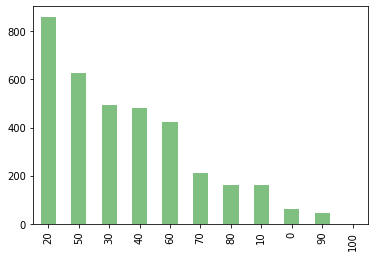

In [ ]:
# 명목형 변수인 Age를 시각화 해본다.
df1.age = df1.age.str.replace('s','',regex=True)                       # 's' 제거.
age_counts = df1.age.value_counts()                                   # 도수표.
age_counts = age_counts.sort_values(ascending=False)
age_counts.plot.bar(color='green', alpha=0.5)
plt.show()

### 연령대 별 사망률 

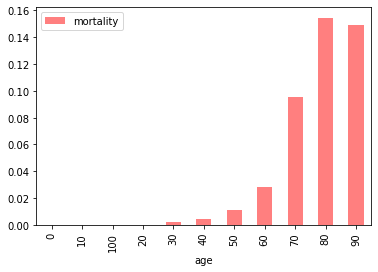

In [ ]:
# Age별 사망비율.
ct = pd.crosstab(df1.age, df1.state=='deceased')
ct.columns = ['alive','deceased']
ct['mortality'] = ct.deceased/(ct.alive + ct.deceased)
ct.sort_values(by=['age'], ascending=True)[['mortality']].plot.bar(color='red', alpha=0.5)   # mortality로 소팅 및 시각화.
plt.show()

### 회복기간 = 확진날짜 - 퇴원날짜

나이순으로 정렬하고 결측치를 제거한다.

released date의 결측치에는 사망자 등을 포함되었을 것으로 예상

In [ ]:
patient = df1[['age','confirmed_date','released_date']]
patient = patient.sort_values(by=["age"], ascending=[True] )
patient

,age,confirmed_date,released_date
2501,0,2020-03-01,2020-03-18
1870,0,2020-03-25,NaN
523,0,2020-04-03,NaN
120,0,2020-03-08,NaN
3673,0,2020-04-17,NaN
...,...,...,...
3591,NaN,2020-02-29,NaN
3592,NaN,2020-02-29,NaN
3898,NaN,2020-02-26,NaN
3899,NaN,2020-02-26,NaN


In [ ]:
patient = patient.dropna()
patient = patient.reset_index(drop =True)

confirmed_date 와 released_date 를 통해 회복 기간을 계산하기 위하여 '-'를 제거해주는 함수를 설정하고 각 열에 적용해 준다,

In [ ]:
def changestr(date):
    d = date.split('-')
    return ''.join(d)

In [ ]:
patient['str_confirmed_date'] = patient['confirmed_date'].apply(changestr)
patient['str_released_date'] = patient['released_date'].apply(changestr)

datetime 모듈을 불러오고 released_date에서 confirmed_date를 빼준다. 회복 기간(recovery periods)를 반환한다.

In [ ]:
from datetime import datetime

def interval_between_date(str_confirmed_date, str_released_date):
  
  recovery_periods = (datetime.strptime(str_released_date, '%Y%m%d').date() - datetime.strptime(str_confirmed_date, '%Y%m%d').date()).days
  return recovery_periods

In [ ]:
patient = patient.dropna()

In [ ]:
# str_confirmed_date = pd.DataFrame(patient.str_confirmed_date)
# str_confirmed_date

In [ ]:
# str_released_date = pd.DataFrame(patient.str_released_date)
# str_released_date

In [ ]:
a = []
for c, r in zip(patient.str_confirmed_date, patient.str_released_date):
    a.append(interval_between_date(c, r))
a = pd.DataFrame(a)
a.columns = ['recovery_periods']

In [ ]:
patient = patient.dropna()
patient = patient.drop(['str_confirmed_date', 'str_released_date'], axis=1)

recovery_periods를 표에 합쳐준다.

In [ ]:
patient['recovery_periods'] = a['recovery_periods']
patient

,age,confirmed_date,released_date,recovery_periods
0,0,2020-03-01,2020-03-18,17
1,0,2020-03-10,2020-03-26,16
2,0,2020-03-01,2020-03-18,17
3,0,2020-03-05,2020-03-19,14
4,0,2020-03-02,2020-03-16,14
...,...,...,...,...
1494,90,2020-04-09,2020-05-12,33
1495,90,2020-03-30,2020-04-18,19
1496,90,2020-03-07,2020-03-31,24
1497,90,2020-03-07,2020-03-21,14


나이를 기준으로 그룹화하고 각 나이대의 회복기간의 평균을 계산한다.
이를 시각화한다.

In [ ]:
recovery = patient.groupby(['age'])['recovery_periods'].mean()
recovery = pd.DataFrame(recovery.apply(pd.to_numeric))
recovery = recovery.sort_values(by = 'age', ascending=True)
recovery = recovery.drop(['100'])
recovery.reset_index(inplace = True)
recovery = recovery[['age', 'recovery_periods']]
# recovery = recovery.drop(['age'], axis=1, inplace=True )
ages = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
recovery['ages'] = ages

recovery

,age,recovery_periods,ages
0,0,21.88,0-9
1,10,20.55,10-19
2,20,22.85,20-29
3,30,22.66,30-39
4,40,23.42,40-49
5,50,23.70,50-59
6,60,26.41,60-69
7,70,31.34,70-79
8,80,34.73,80-89
9,90,28.79,90-99


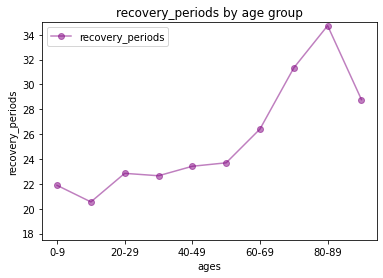

In [ ]:
recovery.plot(x = 'ages', y = 'recovery_periods',color='purple', marker='o', linestyle='solid', alpha=0.5)
plt.title('recovery_periods by age group')
plt.ylim(17.5, 35)  # y축의 최솟값과 최댓값 지정
plt.ylabel('recovery_periods')
plt.legend()
plt.show()

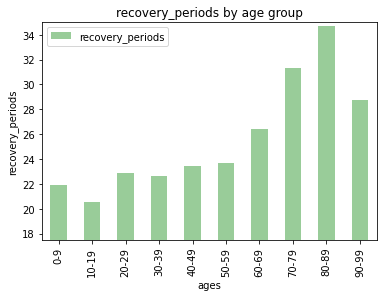

In [ ]:
recovery.plot.bar(x = 'ages', y = 'recovery_periods', color='green', alpha=0.4)
plt.title('recovery_periods by age group')
plt.ylim(17.5, 35)  # y축의 최솟값과 최댓값 지정
plt.ylabel('recovery_periods')
plt.legend()
plt.show()

노령층으로 갈수록 회복기간이 길어진다는 것을 확인할 수 있었다.

90대의 회복기간이 70, 80대 보다 짧은 이유:
90대는 회복해서 퇴원한 경우보다 사망에 이르른 경우가 많았다(치명률). 그런데 사망자 혹은 무증상 격리자의 경우 결측치 제거 시에 데이터가 삭제되었기 때문에 기간이 오래 걸렸더라도 회복한 경우가 있었던 70, 80대 보다 해당 수치가 낮게 나온 것.

In [ ]:
age_state = df1[['age', 'state']]
age_90_state = age_state[age_state['age'] =='90']
age_90_state.reset_index(drop='index',inplace = True)
age_90_state = pd.DataFrame(age_90_state.groupby(['state'])['age'].count())
age_90_state = age_90_state.rename(columns = {'age' : '90s'})
age_90_state.reset_index(inplace = True)
age_90_state = age_90_state[['state', '90s']]
age_90_state

,state,90s
0,deceased,7
1,isolated,25
2,released,15


In [ ]:
age_state = df1[['age', 'state']]
age_80_state = age_state[age_state['age'] =='80']
age_80_state.reset_index(drop='index',inplace = True)
age_80_state = pd.DataFrame(age_80_state.groupby(['state'])['age'].count())
age_80_state = age_80_state.rename(columns = {'age' : '80s'})
age_80_state.reset_index(inplace = True)
age_80_state = age_80_state[['state', '80s']]
age_80_state

,state,80s
0,deceased,25
1,isolated,69
2,released,68


In [ ]:
state_age_joined = age_80_state.merge(age_90_state, left_on = 'state', right_on = 'state' , how='inner')
state_age_joined

,state,80s,90s
0,deceased,25,7
1,isolated,69,25
2,released,68,15


In [ ]:
morality_rate_80s = state_age_joined['80s'][0] / state_age_joined['80s'].sum() * 100
morality_rate_90s = state_age_joined['90s'][0] / state_age_joined['90s'].sum() * 100
print('morality_rate_80s:', morality_rate_80s, '%')
print('morality_rate_90s:', morality_rate_90s, '%')

morality_rate_80s: 15.432098765432098 %
morality_rate_90s: 14.893617021276595 %
